# Assignment 5 -- Contrastive Learning

Please submit this file to Luminus by **23:59 on 20 Mar**. 

---


1. Finish 2 tasks according to the instructions. Only change the code in the required area and DO NOT change others or add new code/text snippets.
2. Rename this file as "Student_number.ipynb". e.g., 'A0000000J.ipynb'. 

3. Submit the file to /Files/assignments/submission/assignment5. 

Please follow the instructions strictly, otherwise you might be penalized.

If you has any questions, please propose it on Slack, or contact Ziheng Qin (e0823059@u.nus.edu) and Yong Liu (e0672130@u.nus.edu).

First, we import the dataset and define transformation operations on it. We apply random transformation on images (crop + flip + colorjitter + grayscale).

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#!HOROVOD_WITH_PYTORCH=1 pip install horovod[pytorch]

In [3]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10


class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            pos_1 = self.transform(img)
            pos_2 = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return pos_1, pos_2, target


train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

We use commonly used ResNet-50 as ConvNet encoders for simplicity in the original paper. The task 1 is to set encoder and projection head. The parameters are adapted from the original paper.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # ----------------------------------------------------------------------
        # START OF YOUR CODE
        # ----------------------------------------------------------------------
        # Task 1
        # set a neural network base encoder self.f
        # hint: nn.Sequential
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.f = nn.Sequential(*self.f)


        # set a small neural network projection head
        # Dense-> Relu-> Dense (2-layer MLP to project the representation to a 128-dimensional latent space and 
        # the representation is 2048-dimensional here)
        # Reference : https://github.com/leftthomas/SimCLR/blob/master/model.py
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))
     

        
        # ----------------------------------------------------------------------
        # END OF YOUR CODE
        # ----------------------------------------------------------------------
    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)


We train encoder network and projection head to maximize agreement using a contrastive loss. The default epoch is 1 for time efficiency while it could takes about 10 minutes to run for one epoch in google colab. The task 2 is to calculate the contrastive loss.
To evaluate the influence of temperature value for contrastive loss, we run this training process 3 times with different temperature value (0.1,0.5 and 1.0).

In [ ]:
import argparse
import os

import pandas as pd
import torch
import torch.optim as optim
!pip install thop
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm


from gdrive.MyDrive.CS5260Project.pytorch_lamb_master.optim.lamb import create_lamb_optimizer
from gdrive.MyDrive.CS5260Project.pytorch_lamb_master.optim import lr_scheduler
import math

def contrastive_loss(out_1, out_2, temperature):

    # ------------------------------------------------------------------
    # START OF YOUR CODE
    # ------------------------------------------------------------------
    # Task2: implement contrastive loss function and return loss variable
    # hint: loss formula could refer to the slides
    # input: out_1, out_2，temperature
    # output: loss variable

    out = torch.cat([out_1, out_2], dim=0)
    # [2*B, 2*B]
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
    # [2*B, 2*B-1]
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    # compute loss
    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    # [2*B]
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
    loss = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean() 

    # ------------------------------------------------------------------
    # END OF YOUR CODE
    # ------------------------------------------------------------------

    return loss

# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, train_scheduler, temperature):
    net.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for pos_1, pos_2, target in train_bar:
        pos_1, pos_2 = pos_1.cuda(non_blocking=True), pos_2.cuda(non_blocking=True)
        feature_1, out_1 = net(pos_1)
        feature_2, out_2 = net(pos_2)

        loss = contrastive_loss(out_1, out_2, temperature)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()
        train_scheduler.step()

        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))

    return total_loss / total_num


# test for one epoch, use weighted knn to find the most similar images' label to assign the test image
def test(net, memory_data_loader, test_data_loader, temperature):
    net.eval()
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature, out = net(data.cuda(non_blocking=True))
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, _, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature, out = net(data)

            total_num += data.size(0)
            # compute cos similarity between each feature vector and feature bank ---> [B, N]
            sim_matrix = torch.mm(feature, feature_bank)
            # [B, K]
            sim_weight, sim_indices = sim_matrix.topk(k=k, dim=-1)
            # [B, K]
            sim_labels = torch.gather(feature_labels.expand(data.size(0), -1), dim=-1, index=sim_indices)
            sim_weight = (sim_weight / temperature).exp()

            # counts for each class
            one_hot_label = torch.zeros(data.size(0) * k, c, device=sim_labels.device)
            # [B*K, C]
            one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
            # weighted score ---> [B, C]
            pred_scores = torch.sum(one_hot_label.view(data.size(0), -1, c) * sim_weight.unsqueeze(dim=-1), dim=1)

            pred_labels = pred_scores.argsort(dim=-1, descending=True)
            total_top1 += torch.sum((pred_labels[:, :1] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            total_top5 += torch.sum((pred_labels[:, :5] == target.unsqueeze(dim=-1)).any(dim=-1).float()).item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}% Acc@5:{:.2f}%'
                                     .format(epoch, epochs, total_top1 / total_num * 100, total_top5 / total_num * 100))

    return total_top1 / total_num * 100, total_top5 / total_num * 100

# Train SimCLR
   
# Feature dim for latent vector, Temperature used in softmax, Top k most similar images used to predict the label
feature_dim, temp, k = 128, [0.1, 0.5, 1], 200
# Number of images in each mini-batch, Number of sweeps over the dataset to train 
#batch_size, epochs = 128, 30
batch_size, epochs = 128, 501
# data prepare
train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True,
                          drop_last=True)
memory_data = CIFAR10Pair(root='data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = CIFAR10Pair(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
import torch
torch.cuda.is_available()

IterationStr='It1'
pathtosave='/content/gdrive/MyDrive/CS5260Project/results/Simclr_LAMB'+'/Iteration'+IterationStr+'/'

# training loop
temp0=temp[0]

# model setup and optimizer config
model = Model(feature_dim).cuda()
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))


#optimizer=create_optimizer_lars(model, lr=2.0,epsilon=1e-5, momentum=0.9, weight_decay=1e-4,bn_bias_separately=True)
optimizer=create_lamb_optimizer(model,lr=4/math.pow(2.0,4.0)/100.0, weight_decay=1.5,bias_correction=None)
warmup_steps_set=math.floor(2.5/math.pow(2.0,4.0)*len(train_loader))
scheduler=lr_scheduler.PolynomialWarmup(optimizer, decay_steps= epochs*len(train_loader),warmup_steps=warmup_steps_set,end_lr=0.0,power=1.0,last_epoch=-1)

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-6)

#exponentially increase learning rate from low to high
def lrs(batch):
    low = math.log2(3.0)
    high = math.log2(100)
    return 2**(low+(high-low)*batch/len(train_loader)/epochs)

# lr_scheduler
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lrs)


c = len(memory_data.classes)

results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []}
save_name_pre = '{}_{}_{}_{}_{}'.format(feature_dim, temp0, k, batch_size, epochs)
if not os.path.exists(pathtosave):
    os.makedirs(pathtosave)
best_acc = 0.0

train_loss_epoch=torch.zeros(epochs)
test_acc_1_epoch=torch.zeros(epochs)
test_acc_5_epoch=torch.zeros(epochs)
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, scheduler, temp0)
    train_loss_epoch[epoch-1]=train_loss


    print(optimizer.param_groups[0]['lr'])
        
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, temp0)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv(pathtosave+'{}_statistics.csv'.format(save_name_pre), index_label='epoch')
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save(model.state_dict(), pathtosave+'{}_model.pth'.format(save_name_pre))
    test_acc_1_epoch[epoch-1]=test_acc_1
    test_acc_5_epoch[epoch-1]=test_acc_5
    

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/thop/vision/basic_hooks.py:92: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  kernel = torch.DoubleTensor([*(x[0].shape[2:])]) // torch.DoubleTensor(list((m.output_size,))).squeeze()


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torchvision.models.resnet.Bottleneck'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.
# Model Params: 24.62M FLOPs: 1.31G


  0%|          | 0/390 [00:00<?, ?it/s]/content/gdrive/MyDrive/CS5260Project/pytorch_lamb_master/optim/lamb.py:89: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
Train Epoch: [1/501] Loss: 4.2467: 100%|██████████| 390/390 [01:01<00:00,  6.36it/s]


0.002495776378436492


Train Epoch: [2/501] Loss: 2.7056: 100%|██████████| 390/390 [01:01<00:00,  6.37it/s]


0.002490784825679619


Train Epoch: [3/501] Loss: 2.1949: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002485793272922746


Train Epoch: [4/501] Loss: 1.9378: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.002480801720165873


Train Epoch: [5/501] Loss: 1.7720: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0024758101674090005


Train Epoch: [6/501] Loss: 1.6642: 100%|██████████| 390/390 [01:01<00:00,  6.35it/s]


0.002470818614652127


Train Epoch: [7/501] Loss: 1.5524: 100%|██████████| 390/390 [01:01<00:00,  6.37it/s]


0.002465827061895254


Train Epoch: [8/501] Loss: 1.4982: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0024608355091383814


Train Epoch: [9/501] Loss: 1.4338: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0024558439563815084


Train Epoch: [10/501] Loss: 1.4049: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0024508524036246353


Train Epoch: [11/501] Loss: 1.3521: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0024458608508677623


Train Epoch: [12/501] Loss: 1.3337: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0024408692981108893


Train Epoch: [13/501] Loss: 1.3013: 100%|██████████| 390/390 [01:01<00:00,  6.37it/s]


0.0024358777453540163


Train Epoch: [14/501] Loss: 1.2661: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0024308861925971433


Train Epoch: [15/501] Loss: 1.2383: 100%|██████████| 390/390 [01:01<00:00,  6.37it/s]


0.0024258946398402702


Train Epoch: [16/501] Loss: 1.2297: 100%|██████████| 390/390 [01:01<00:00,  6.36it/s]


0.002420903087083397


Train Epoch: [17/501] Loss: 1.1993: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0024159115343265246


Train Epoch: [18/501] Loss: 1.1824: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0024109199815696516


Train Epoch: [19/501] Loss: 1.1633: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002405928428812778


Train Epoch: [20/501] Loss: 1.1593: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0024009368760559056


Train Epoch: [21/501] Loss: 1.1464: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0023959453232990325


Train Epoch: [22/501] Loss: 1.1183: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0023909537705421595


Train Epoch: [23/501] Loss: 1.1128: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023859622177852865


Train Epoch: [24/501] Loss: 1.1025: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0023809706650284135


Train Epoch: [25/501] Loss: 1.0788: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0023759791122715404


Train Epoch: [26/501] Loss: 1.0602: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002370987559514668


Train Epoch: [27/501] Loss: 1.0559: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023659960067577944


Train Epoch: [28/501] Loss: 1.0424: 100%|██████████| 390/390 [01:00<00:00,  6.41it/s]


0.0023610044540009214


Train Epoch: [29/501] Loss: 1.0422: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002356012901244049


Train Epoch: [30/501] Loss: 1.0324: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023510213484871758


Train Epoch: [31/501] Loss: 1.0215: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0023460297957303027


Train Epoch: [32/501] Loss: 1.0121: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0023410382429734293


Train Epoch: [33/501] Loss: 0.9998: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0023360466902165567


Train Epoch: [34/501] Loss: 0.9937: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023310551374596837


Train Epoch: [35/501] Loss: 0.9895: 100%|██████████| 390/390 [01:00<00:00,  6.41it/s]


0.0023260635847028107


Train Epoch: [36/501] Loss: 0.9819: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023210720319459376


Train Epoch: [37/501] Loss: 0.9698: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023160804791890646


Train Epoch: [38/501] Loss: 0.9756: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0023110889264321916


Train Epoch: [39/501] Loss: 0.9567: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002306097373675319


Train Epoch: [40/501] Loss: 0.9520: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0023011058209184455


Train Epoch: [41/501] Loss: 0.9416: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0022961142681615725


Train Epoch: [42/501] Loss: 0.9428: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0022911227154047


Train Epoch: [43/501] Loss: 0.9443: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002286131162647827


Train Epoch: [44/501] Loss: 0.9312: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002281139609890954


Train Epoch: [45/501] Loss: 0.9286: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002276148057134081


Train Epoch: [46/501] Loss: 0.9126: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.002271156504377208


Train Epoch: [47/501] Loss: 0.9121: 100%|██████████| 390/390 [01:01<00:00,  6.37it/s]


0.002266164951620335


Train Epoch: [48/501] Loss: 0.9060: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.002261173398863462


Train Epoch: [49/501] Loss: 0.9079: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0022561818461065888


Train Epoch: [50/501] Loss: 0.8915: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0022511902933497157


Train Epoch: [51/501] Loss: 0.8993: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002246198740592843


Train Epoch: [52/501] Loss: 0.8963: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.00224120718783597


Train Epoch: [53/501] Loss: 0.8911: 100%|██████████| 390/390 [01:00<00:00,  6.41it/s]


0.0022362156350790967


Train Epoch: [54/501] Loss: 0.8807: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002231224082322224


Train Epoch: [55/501] Loss: 0.8894: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002226232529565351


Train Epoch: [56/501] Loss: 0.8817: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002221240976808478


Train Epoch: [57/501] Loss: 0.8722: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002216249424051605


Train Epoch: [58/501] Loss: 0.8602: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.002211257871294732


Train Epoch: [59/501] Loss: 0.8623: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002206266318537859


Train Epoch: [60/501] Loss: 0.8601: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.0022012747657809864


Train Epoch: [61/501] Loss: 0.8546: 100%|██████████| 390/390 [01:00<00:00,  6.40it/s]


0.002196283213024113


Train Epoch: [62/501] Loss: 0.8487: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.00219129166026724


Train Epoch: [63/501] Loss: 0.8441: 100%|██████████| 390/390 [01:01<00:00,  6.39it/s]


0.0021863001075103673


Train Epoch: [64/501] Loss: 0.8427: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0021813085547534943


Train Epoch: [65/501] Loss: 0.8409: 100%|██████████| 390/390 [01:00<00:00,  6.39it/s]


0.0021763170019966213


Train Epoch: [66/501] Loss: 0.8427: 100%|██████████| 390/390 [01:01<00:00,  6.38it/s]


0.0021713254492397483


Train Epoch: [67/501] Loss: 0.8273: 100%|██████████| 390/390 [01:01<00:00,  6.36it/s]


0.0021663338964828752


Train Epoch: [68/501] Loss: 0.8384: 100%|██████████| 390/390 [01:01<00:00,  6.35it/s]


0.002161342343726002


Train Epoch: [69/501] Loss: 0.8313: 100%|██████████| 390/390 [01:01<00:00,  6.37it/s]


0.002156350790969129


Train Epoch: [70/501] Loss: 0.8239: 100%|██████████| 390/390 [01:01<00:00,  6.36it/s]


0.002151359238212256


Train Epoch: [71/501] Loss: 0.8103: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.002146367685455383


Train Epoch: [72/501] Loss: 0.8155: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0021413761326985106


Train Epoch: [73/501] Loss: 0.8164: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0021363845799416375


Train Epoch: [74/501] Loss: 0.8090: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.002131393027184764


Train Epoch: [75/501] Loss: 0.8016: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0021264014744278915


Train Epoch: [76/501] Loss: 0.8066: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0021214099216710185


Train Epoch: [77/501] Loss: 0.8104: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0021164183689141454


Train Epoch: [78/501] Loss: 0.8003: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0021114268161572724


Train Epoch: [79/501] Loss: 0.7929: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0021064352634003994


Train Epoch: [80/501] Loss: 0.7967: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0021014437106435264


Train Epoch: [81/501] Loss: 0.7944: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0020964521578866534


Train Epoch: [82/501] Loss: 0.7886: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0020914606051297803


Train Epoch: [83/501] Loss: 0.7924: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0020864690523729073


Train Epoch: [84/501] Loss: 0.7943: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020814774996160347


Train Epoch: [85/501] Loss: 0.7766: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020764859468591617


Train Epoch: [86/501] Loss: 0.7780: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.0020714943941022882


Train Epoch: [87/501] Loss: 0.7778: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.0020665028413454157


Train Epoch: [88/501] Loss: 0.7687: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0020615112885885426


Train Epoch: [89/501] Loss: 0.7660: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0020565197358316696


Train Epoch: [90/501] Loss: 0.7649: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0020515281830747966


Train Epoch: [91/501] Loss: 0.7626: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020465366303179236


Train Epoch: [92/501] Loss: 0.7579: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020415450775610505


Train Epoch: [93/501] Loss: 0.7599: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020365535248041775


Train Epoch: [94/501] Loss: 0.7581: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0020315619720473045


Train Epoch: [95/501] Loss: 0.7457: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.0020265704192904315


Train Epoch: [96/501] Loss: 0.7542: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020215788665335585


Train Epoch: [97/501] Loss: 0.7475: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.002016587313776686


Train Epoch: [98/501] Loss: 0.7449: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.002011595761019813


Train Epoch: [99/501] Loss: 0.7468: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020066042082629394


Train Epoch: [100/501] Loss: 0.7468: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0020016126555060664


Train Epoch: [101/501] Loss: 0.7445: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019966211027491938


Train Epoch: [102/501] Loss: 0.7487: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0019916295499923208


Train Epoch: [103/501] Loss: 0.7317: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0019866379972354477


Train Epoch: [104/501] Loss: 0.7409: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0019816464444785747


Train Epoch: [105/501] Loss: 0.7435: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019766548917217017


Train Epoch: [106/501] Loss: 0.7346: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0019716633389648287


Train Epoch: [107/501] Loss: 0.7369: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019666717862079556


Train Epoch: [108/501] Loss: 0.7332: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.0019616802334510826


Train Epoch: [109/501] Loss: 0.7279: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0019566886806942096


Train Epoch: [110/501] Loss: 0.7364: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019516971279373368


Train Epoch: [111/501] Loss: 0.7292: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019467055751804638


Train Epoch: [112/501] Loss: 0.7278: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019417140224235907


Train Epoch: [113/501] Loss: 0.7184: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.001936722469666718


Train Epoch: [114/501] Loss: 0.7167: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001931730916909845


Train Epoch: [115/501] Loss: 0.7275: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001926739364152972


Train Epoch: [116/501] Loss: 0.7094: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001921747811396099


Train Epoch: [117/501] Loss: 0.7177: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0019167562586392259


Train Epoch: [118/501] Loss: 0.7079: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0019117647058823528


Train Epoch: [119/501] Loss: 0.7118: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.00190677315312548


Train Epoch: [120/501] Loss: 0.7031: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001901781600368607


Train Epoch: [121/501] Loss: 0.7070: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.001896790047611734


Train Epoch: [122/501] Loss: 0.7064: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018917984948548612


Train Epoch: [123/501] Loss: 0.7065: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001886806942097988


Train Epoch: [124/501] Loss: 0.7016: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001881815389341115


Train Epoch: [125/501] Loss: 0.7049: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.001876823836584242


Train Epoch: [126/501] Loss: 0.7042: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001871832283827369


Train Epoch: [127/501] Loss: 0.6953: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001866840731070496


Train Epoch: [128/501] Loss: 0.6907: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0018618491783136233


Train Epoch: [129/501] Loss: 0.6931: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018568576255567502


Train Epoch: [130/501] Loss: 0.6948: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001851866072799877


Train Epoch: [131/501] Loss: 0.6853: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018468745200430042


Train Epoch: [132/501] Loss: 0.6866: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018418829672861312


Train Epoch: [133/501] Loss: 0.6829: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0018368914145292581


Train Epoch: [134/501] Loss: 0.6780: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018318998617723853


Train Epoch: [135/501] Loss: 0.6815: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018269083090155123


Train Epoch: [136/501] Loss: 0.6843: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001821916756258639


Train Epoch: [137/501] Loss: 0.6830: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018169252035017663


Train Epoch: [138/501] Loss: 0.6755: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0018119336507448932


Train Epoch: [139/501] Loss: 0.6918: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018069420979880202


Train Epoch: [140/501] Loss: 0.6787: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0018019505452311474


Train Epoch: [141/501] Loss: 0.6790: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017969589924742744


Train Epoch: [142/501] Loss: 0.6718: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0017919674397174014


Train Epoch: [143/501] Loss: 0.6654: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0017869758869605286


Train Epoch: [144/501] Loss: 0.6641: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017819843342036553


Train Epoch: [145/501] Loss: 0.6739: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0017769927814467823


Train Epoch: [146/501] Loss: 0.6640: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017720012286899095


Train Epoch: [147/501] Loss: 0.6645: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017670096759330365


Train Epoch: [148/501] Loss: 0.6647: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017620181231761635


Train Epoch: [149/501] Loss: 0.6573: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017570265704192907


Train Epoch: [150/501] Loss: 0.6684: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0017520350176624174


Train Epoch: [151/501] Loss: 0.6594: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0017470434649055444


Train Epoch: [152/501] Loss: 0.6515: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0017420519121486716


Train Epoch: [153/501] Loss: 0.6537: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0017370603593917986


Train Epoch: [154/501] Loss: 0.6538: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0017320688066349255


Train Epoch: [155/501] Loss: 0.6419: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017270772538780527


Train Epoch: [156/501] Loss: 0.6420: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0017220857011211797


Train Epoch: [157/501] Loss: 0.6446: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017170941483643065


Train Epoch: [158/501] Loss: 0.6425: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017121025956074337


Train Epoch: [159/501] Loss: 0.6384: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0017071110428505606


Train Epoch: [160/501] Loss: 0.6409: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0017021194900936876


Train Epoch: [161/501] Loss: 0.6392: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0016971279373368148


Train Epoch: [162/501] Loss: 0.6396: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0016921363845799418


Train Epoch: [163/501] Loss: 0.6368: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0016871448318230686


Train Epoch: [164/501] Loss: 0.6411: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001682153279066196


Train Epoch: [165/501] Loss: 0.6397: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0016771617263093227


Train Epoch: [166/501] Loss: 0.6271: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0016721701735524497


Train Epoch: [167/501] Loss: 0.6320: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.001667178620795577


Train Epoch: [168/501] Loss: 0.6306: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0016621870680387037


Train Epoch: [169/501] Loss: 0.6290: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0016571955152818309


Train Epoch: [170/501] Loss: 0.6311: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001652203962524958


Train Epoch: [171/501] Loss: 0.6261: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0016472124097680846


Train Epoch: [172/501] Loss: 0.6256: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0016422208570112118


Train Epoch: [173/501] Loss: 0.6235: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001637229304254339


Train Epoch: [174/501] Loss: 0.6302: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0016322377514974657


Train Epoch: [175/501] Loss: 0.6157: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001627246198740593


Train Epoch: [176/501] Loss: 0.6187: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0016222546459837201


Train Epoch: [177/501] Loss: 0.6243: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0016172630932268467


Train Epoch: [178/501] Loss: 0.6169: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0016122715404699739


Train Epoch: [179/501] Loss: 0.6214: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.001607279987713101


Train Epoch: [180/501] Loss: 0.6173: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0016022884349562278


Train Epoch: [181/501] Loss: 0.6153: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001597296882199355


Train Epoch: [182/501] Loss: 0.6166: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0015923053294424822


Train Epoch: [183/501] Loss: 0.6148: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0015873137766856088


Train Epoch: [184/501] Loss: 0.6148: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001582322223928736


Train Epoch: [185/501] Loss: 0.6096: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0015773306711718631


Train Epoch: [186/501] Loss: 0.6129: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.00157233911841499


Train Epoch: [187/501] Loss: 0.6046: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.001567347565658117


Train Epoch: [188/501] Loss: 0.6050: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001562356012901244


Train Epoch: [189/501] Loss: 0.6055: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0015573644601443708


Train Epoch: [190/501] Loss: 0.6017: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0015523729073874983


Train Epoch: [191/501] Loss: 0.6011: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001547381354630625


Train Epoch: [192/501] Loss: 0.6038: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001542389801873752


Train Epoch: [193/501] Loss: 0.5997: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0015373982491168792


Train Epoch: [194/501] Loss: 0.6053: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0015324066963600062


Train Epoch: [195/501] Loss: 0.6001: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0015274151436031331


Train Epoch: [196/501] Loss: 0.5946: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0015224235908462603


Train Epoch: [197/501] Loss: 0.5996: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001517432038089387


Train Epoch: [198/501] Loss: 0.5938: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001512440485332514


Train Epoch: [199/501] Loss: 0.5923: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0015074489325756413


Train Epoch: [200/501] Loss: 0.5942: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0015024573798187682


Train Epoch: [201/501] Loss: 0.5945: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014974658270618952


Train Epoch: [202/501] Loss: 0.5955: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0014924742743050224


Train Epoch: [203/501] Loss: 0.5891: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014874827215481494


Train Epoch: [204/501] Loss: 0.5821: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014824911687912762


Train Epoch: [205/501] Loss: 0.5854: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014774996160344033


Train Epoch: [206/501] Loss: 0.5874: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0014725080632775303


Train Epoch: [207/501] Loss: 0.5751: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.0014675165105206573


Train Epoch: [208/501] Loss: 0.5866: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014625249577637845


Train Epoch: [209/501] Loss: 0.5761: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0014575334050069115


Train Epoch: [210/501] Loss: 0.5797: 100%|██████████| 390/390 [01:02<00:00,  6.29it/s]


0.0014525418522500382


Train Epoch: [211/501] Loss: 0.5733: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014475502994931654


Train Epoch: [212/501] Loss: 0.5805: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014425587467362924


Train Epoch: [213/501] Loss: 0.5839: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0014375671939794194


Train Epoch: [214/501] Loss: 0.5789: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0014325756412225466


Train Epoch: [215/501] Loss: 0.5746: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.0014275840884656736


Train Epoch: [216/501] Loss: 0.5856: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0014225925357088003


Train Epoch: [217/501] Loss: 0.5747: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0014176009829519277


Train Epoch: [218/501] Loss: 0.5698: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0014126094301950545


Train Epoch: [219/501] Loss: 0.5647: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0014076178774381815


Train Epoch: [220/501] Loss: 0.5659: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0014026263246813087


Train Epoch: [221/501] Loss: 0.5676: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013976347719244356


Train Epoch: [222/501] Loss: 0.5575: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013926432191675626


Train Epoch: [223/501] Loss: 0.5655: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013876516664106898


Train Epoch: [224/501] Loss: 0.5682: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0013826601136538166


Train Epoch: [225/501] Loss: 0.5687: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013776685608969436


Train Epoch: [226/501] Loss: 0.5683: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013726770081400707


Train Epoch: [227/501] Loss: 0.5617: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013676854553831977


Train Epoch: [228/501] Loss: 0.5609: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013626939026263247


Train Epoch: [229/501] Loss: 0.5653: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001357702349869452


Train Epoch: [230/501] Loss: 0.5544: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013527107971125789


Train Epoch: [231/501] Loss: 0.5517: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013477192443557056


Train Epoch: [232/501] Loss: 0.5595: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013427276915988328


Train Epoch: [233/501] Loss: 0.5530: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013377361388419598


Train Epoch: [234/501] Loss: 0.5523: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013327445860850868


Train Epoch: [235/501] Loss: 0.5624: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001327753033328214


Train Epoch: [236/501] Loss: 0.5556: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001322761480571341


Train Epoch: [237/501] Loss: 0.5523: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013177699278144677


Train Epoch: [238/501] Loss: 0.5574: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001312778375057595


Train Epoch: [239/501] Loss: 0.5426: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0013077868223007219


Train Epoch: [240/501] Loss: 0.5556: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0013027952695438489


Train Epoch: [241/501] Loss: 0.5470: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001297803716786976


Train Epoch: [242/501] Loss: 0.5526: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001292812164030103


Train Epoch: [243/501] Loss: 0.5463: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.00128782061127323


Train Epoch: [244/501] Loss: 0.5439: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0012828290585163572


Train Epoch: [245/501] Loss: 0.5382: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001277837505759484


Train Epoch: [246/501] Loss: 0.5495: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001272845953002611


Train Epoch: [247/501] Loss: 0.5422: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012678544002457381


Train Epoch: [248/501] Loss: 0.5360: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001262862847488865


Train Epoch: [249/501] Loss: 0.5442: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001257871294731992


Train Epoch: [250/501] Loss: 0.5445: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012528797419751193


Train Epoch: [251/501] Loss: 0.5410: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.001247888189218246


Train Epoch: [252/501] Loss: 0.5307: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001242896636461373


Train Epoch: [253/501] Loss: 0.5358: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012379050837045


Train Epoch: [254/501] Loss: 0.5332: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012329135309476272


Train Epoch: [255/501] Loss: 0.5314: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0012279219781907542


Train Epoch: [256/501] Loss: 0.5330: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012229304254338812


Train Epoch: [257/501] Loss: 0.5336: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0012179388726770084


Train Epoch: [258/501] Loss: 0.5306: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012129473199201351


Train Epoch: [259/501] Loss: 0.5373: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.001207955767163262


Train Epoch: [260/501] Loss: 0.5310: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0012029642144063893


Train Epoch: [261/501] Loss: 0.5289: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011979726616495163


Train Epoch: [262/501] Loss: 0.5245: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0011929811088926432


Train Epoch: [263/501] Loss: 0.5183: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0011879895561357704


Train Epoch: [264/501] Loss: 0.5263: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011829980033788972


Train Epoch: [265/501] Loss: 0.5229: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011780064506220242


Train Epoch: [266/501] Loss: 0.5269: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011730148978651514


Train Epoch: [267/501] Loss: 0.5175: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0011680233451082783


Train Epoch: [268/501] Loss: 0.5186: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011630317923514053


Train Epoch: [269/501] Loss: 0.5251: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0011580402395945325


Train Epoch: [270/501] Loss: 0.5184: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011530486868376595


Train Epoch: [271/501] Loss: 0.5198: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011480571340807863


Train Epoch: [272/501] Loss: 0.5188: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011430655813239135


Train Epoch: [273/501] Loss: 0.5196: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011380740285670404


Train Epoch: [274/501] Loss: 0.5158: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0011330824758101674


Train Epoch: [275/501] Loss: 0.5155: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011280909230532946


Train Epoch: [276/501] Loss: 0.5116: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011230993702964216


Train Epoch: [277/501] Loss: 0.5199: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0011181078175395483


Train Epoch: [278/501] Loss: 0.5150: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011131162647826753


Train Epoch: [279/501] Loss: 0.5149: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011081247120258025


Train Epoch: [280/501] Loss: 0.5132: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0011031331592689295


Train Epoch: [281/501] Loss: 0.5048: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0010981416065120565


Train Epoch: [282/501] Loss: 0.5057: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0010931500537551837


Train Epoch: [283/501] Loss: 0.5120: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010881585009983106


Train Epoch: [284/501] Loss: 0.5053: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010831669482414374


Train Epoch: [285/501] Loss: 0.5031: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010781753954845646


Train Epoch: [286/501] Loss: 0.5082: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010731838427276916


Train Epoch: [287/501] Loss: 0.5090: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0010681922899708186


Train Epoch: [288/501] Loss: 0.5013: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010632007372139457


Train Epoch: [289/501] Loss: 0.4962: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010582091844570727


Train Epoch: [290/501] Loss: 0.5009: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0010532176317001995


Train Epoch: [291/501] Loss: 0.4935: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0010482260789433267


Train Epoch: [292/501] Loss: 0.4984: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010432345261864537


Train Epoch: [293/501] Loss: 0.5044: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010382429734295806


Train Epoch: [294/501] Loss: 0.4987: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0010332514206727078


Train Epoch: [295/501] Loss: 0.4995: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010282598679158348


Train Epoch: [296/501] Loss: 0.5024: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0010232683151589618


Train Epoch: [297/501] Loss: 0.4859: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.001018276762402089


Train Epoch: [298/501] Loss: 0.4933: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010132852096452157


Train Epoch: [299/501] Loss: 0.4987: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0010082936568883427


Train Epoch: [300/501] Loss: 0.4886: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00100330210413147


Train Epoch: [301/501] Loss: 0.4895: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0009983105513745969


Train Epoch: [302/501] Loss: 0.4943: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0009933189986177239


Train Epoch: [303/501] Loss: 0.4871: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.000988327445860851


Train Epoch: [304/501] Loss: 0.4867: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0009833358931039778


Train Epoch: [305/501] Loss: 0.4930: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0009783443403471048


Train Epoch: [306/501] Loss: 0.4827: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0009733527875902321


Train Epoch: [307/501] Loss: 0.4792: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.000968361234833359


Train Epoch: [308/501] Loss: 0.5004: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000963369682076486


Train Epoch: [309/501] Loss: 0.4752: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0009583781293196131


Train Epoch: [310/501] Loss: 0.4823: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00095338657656274


Train Epoch: [311/501] Loss: 0.4838: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.000948395023805867


Train Epoch: [312/501] Loss: 0.4854: 100%|██████████| 390/390 [01:01<00:00,  6.33it/s]


0.0009434034710489942


Train Epoch: [313/501] Loss: 0.4842: 100%|██████████| 390/390 [01:01<00:00,  6.31it/s]


0.000938411918292121


Train Epoch: [314/501] Loss: 0.4820: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.000933420365535248


Train Epoch: [315/501] Loss: 0.4794: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0009284288127783752


Train Epoch: [316/501] Loss: 0.4768: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0009234372600215021


Train Epoch: [317/501] Loss: 0.4791: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0009184457072646291


Train Epoch: [318/501] Loss: 0.4743: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0009134541545077559


Train Epoch: [319/501] Loss: 0.4750: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0009084626017508831


Train Epoch: [320/501] Loss: 0.4776: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0009034710489940101


Train Epoch: [321/501] Loss: 0.4702: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008984794962371371


Train Epoch: [322/501] Loss: 0.4624: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008934879434802643


Train Epoch: [323/501] Loss: 0.4777: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0008884963907233912


Train Epoch: [324/501] Loss: 0.4662: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008835048379665181


Train Epoch: [325/501] Loss: 0.4721: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008785132852096453


Train Epoch: [326/501] Loss: 0.4661: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008735217324527722


Train Epoch: [327/501] Loss: 0.4707: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0008685301796958992


Train Epoch: [328/501] Loss: 0.4673: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0008635386269390264


Train Epoch: [329/501] Loss: 0.4636: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008585470741821532


Train Epoch: [330/501] Loss: 0.4673: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008535555214252802


Train Epoch: [331/501] Loss: 0.4682: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008485639686684074


Train Epoch: [332/501] Loss: 0.4643: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0008435724159115343


Train Epoch: [333/501] Loss: 0.4582: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008385808631546613


Train Epoch: [334/501] Loss: 0.4667: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0008335893103977884


Train Epoch: [335/501] Loss: 0.4619: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008285977576409154


Train Epoch: [336/501] Loss: 0.4614: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.0008236062048840423


Train Epoch: [337/501] Loss: 0.4615: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0008186146521271695


Train Epoch: [338/501] Loss: 0.4659: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0008136230993702965


Train Epoch: [339/501] Loss: 0.4543: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0008086315466134233


Train Epoch: [340/501] Loss: 0.4568: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0008036399938565505


Train Epoch: [341/501] Loss: 0.4543: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007986484410996775


Train Epoch: [342/501] Loss: 0.4537: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007936568883428044


Train Epoch: [343/501] Loss: 0.4491: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007886653355859316


Train Epoch: [344/501] Loss: 0.4577: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007836737828290586


Train Epoch: [345/501] Loss: 0.4543: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007786822300721854


Train Epoch: [346/501] Loss: 0.4533: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007736906773153127


Train Epoch: [347/501] Loss: 0.4511: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007686991245584396


Train Epoch: [348/501] Loss: 0.4498: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007637075718015666


Train Epoch: [349/501] Loss: 0.4464: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007587160190446938


Train Epoch: [350/501] Loss: 0.4509: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007537244662878206


Train Epoch: [351/501] Loss: 0.4523: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007487329135309476


Train Epoch: [352/501] Loss: 0.4484: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007437413607740748


Train Epoch: [353/501] Loss: 0.4488: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007387498080172017


Train Epoch: [354/501] Loss: 0.4508: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007337582552603287


Train Epoch: [355/501] Loss: 0.4474: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007287667025034558


Train Epoch: [356/501] Loss: 0.4452: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007237751497465827


Train Epoch: [357/501] Loss: 0.4488: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0007187835969897097


Train Epoch: [358/501] Loss: 0.4413: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007137920442328369


Train Epoch: [359/501] Loss: 0.4433: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0007088004914759639


Train Epoch: [360/501] Loss: 0.4379: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.0007038089387190907


Train Epoch: [361/501] Loss: 0.4409: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0006988173859622177


Train Epoch: [362/501] Loss: 0.4327: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0006938258332053449


Train Epoch: [363/501] Loss: 0.4412: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0006888342804484718


Train Epoch: [364/501] Loss: 0.4355: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0006838427276915988


Train Epoch: [365/501] Loss: 0.4357: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000678851174934726


Train Epoch: [366/501] Loss: 0.4370: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0006738596221778528


Train Epoch: [367/501] Loss: 0.4389: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0006688680694209798


Train Epoch: [368/501] Loss: 0.4336: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000663876516664107


Train Epoch: [369/501] Loss: 0.4300: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0006588849639072339


Train Epoch: [370/501] Loss: 0.4310: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0006538934111503608


Train Epoch: [371/501] Loss: 0.4298: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.000648901858393488


Train Epoch: [372/501] Loss: 0.4274: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.000643910305636615


Train Epoch: [373/501] Loss: 0.4341: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0006389187528797419


Train Epoch: [374/501] Loss: 0.4284: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0006339272001228691


Train Epoch: [375/501] Loss: 0.4199: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000628935647365996


Train Epoch: [376/501] Loss: 0.4216: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0006239440946091229


Train Epoch: [377/501] Loss: 0.4211: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0006189525418522501


Train Epoch: [378/501] Loss: 0.4254: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0006139609890953771


Train Epoch: [379/501] Loss: 0.4232: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.000608969436338504


Train Epoch: [380/501] Loss: 0.4245: 100%|██████████| 390/390 [01:02<00:00,  6.28it/s]


0.0006039778835816312


Train Epoch: [381/501] Loss: 0.4240: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0005989863308247581


Train Epoch: [382/501] Loss: 0.4249: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000593994778067885


Train Epoch: [383/501] Loss: 0.4187: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005890032253110122


Train Epoch: [384/501] Loss: 0.4228: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005840116725541392


Train Epoch: [385/501] Loss: 0.4164: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0005790201197972662


Train Epoch: [386/501] Loss: 0.4195: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0005740285670403933


Train Epoch: [387/501] Loss: 0.4238: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005690370142835202


Train Epoch: [388/501] Loss: 0.4153: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005640454615266472


Train Epoch: [389/501] Loss: 0.4115: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005590539087697744


Train Epoch: [390/501] Loss: 0.4140: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0005540623560129013


Train Epoch: [391/501] Loss: 0.4087: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0005490708032560282


Train Epoch: [392/501] Loss: 0.4159: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0005440792504991554


Train Epoch: [393/501] Loss: 0.4249: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005390876977422823


Train Epoch: [394/501] Loss: 0.4078: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005340961449854093


Train Epoch: [395/501] Loss: 0.4048: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005291045922285365


Train Epoch: [396/501] Loss: 0.4122: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005241130394716633


Train Epoch: [397/501] Loss: 0.4057: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005191214867147903


Train Epoch: [398/501] Loss: 0.4119: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005141299339579175


Train Epoch: [399/501] Loss: 0.4062: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005091383812010445


Train Epoch: [400/501] Loss: 0.4117: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0005041468284441714


Train Epoch: [401/501] Loss: 0.4072: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004991552756872983


Train Epoch: [402/501] Loss: 0.4033: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004941637229304255


Train Epoch: [403/501] Loss: 0.4072: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004891721701735524


Train Epoch: [404/501] Loss: 0.4060: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004841806174166793


Train Epoch: [405/501] Loss: 0.4053: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00047918906465980657


Train Epoch: [406/501] Loss: 0.4018: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0004741975119029335


Train Epoch: [407/501] Loss: 0.3985: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0004692059591460604


Train Epoch: [408/501] Loss: 0.4041: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.0004642144063891876


Train Epoch: [409/501] Loss: 0.4006: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00045922285363231454


Train Epoch: [410/501] Loss: 0.3942: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.00045423130087544146


Train Epoch: [411/501] Loss: 0.3965: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00044923974811856865


Train Epoch: [412/501] Loss: 0.3995: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0004442481953616956


Train Epoch: [413/501] Loss: 0.3935: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004392566426048225


Train Epoch: [414/501] Loss: 0.4045: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.0004342650898479497


Train Epoch: [415/501] Loss: 0.3938: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004292735370910766


Train Epoch: [416/501] Loss: 0.4021: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.00042428198433420354


Train Epoch: [417/501] Loss: 0.3918: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0004192904315773308


Train Epoch: [418/501] Loss: 0.3872: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0004142988788204577


Train Epoch: [419/501] Loss: 0.3875: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00040930732606358464


Train Epoch: [420/501] Loss: 0.3916: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00040431577330671183


Train Epoch: [421/501] Loss: 0.3930: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00039932422054983875


Train Epoch: [422/501] Loss: 0.3963: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0003943326677929657


Train Epoch: [423/501] Loss: 0.3912: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00038934111503609287


Train Epoch: [424/501] Loss: 0.3910: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.0003843495622792198


Train Epoch: [425/501] Loss: 0.3918: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0003793580095223467


Train Epoch: [426/501] Loss: 0.3912: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0003743664567654739


Train Epoch: [427/501] Loss: 0.3909: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00036937490400860084


Train Epoch: [428/501] Loss: 0.3842: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.00036438335125172776


Train Epoch: [429/501] Loss: 0.3809: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00035939179849485496


Train Epoch: [430/501] Loss: 0.3889: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00035440024573798193


Train Epoch: [431/501] Loss: 0.3893: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00034940869298110886


Train Epoch: [432/501] Loss: 0.3822: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00034441714022423605


Train Epoch: [433/501] Loss: 0.3776: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000339425587467363


Train Epoch: [434/501] Loss: 0.3809: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0003344340347104899


Train Epoch: [435/501] Loss: 0.3798: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0003294424819536171


Train Epoch: [436/501] Loss: 0.3816: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.000324450929196744


Train Epoch: [437/501] Loss: 0.3829: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00031945937643987094


Train Epoch: [438/501] Loss: 0.3743: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00031446782368299813


Train Epoch: [439/501] Loss: 0.3730: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00030947627092612506


Train Epoch: [440/501] Loss: 0.3775: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.000304484718169252


Train Epoch: [441/501] Loss: 0.3751: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0002994931654123789


Train Epoch: [442/501] Loss: 0.3760: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0002945016126555061


Train Epoch: [443/501] Loss: 0.3762: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


0.0002895100598986331


Train Epoch: [444/501] Loss: 0.3712: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00028451850714176


Train Epoch: [445/501] Loss: 0.3726: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0002795269543848872


Train Epoch: [446/501] Loss: 0.3672: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0002745354016280141


Train Epoch: [447/501] Loss: 0.3773: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00026954384887114104


Train Epoch: [448/501] Loss: 0.3751: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00026455229611426823


Train Epoch: [449/501] Loss: 0.3672: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00025956074335739516


Train Epoch: [450/501] Loss: 0.3740: 100%|██████████| 390/390 [01:02<00:00,  6.22it/s]


0.0002545691906005221


Train Epoch: [451/501] Loss: 0.3755: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


0.0002495776378436493


Train Epoch: [452/501] Loss: 0.3678: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0002445860850867762


Train Epoch: [453/501] Loss: 0.3653: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00023959453232990315


Train Epoch: [454/501] Loss: 0.3644: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00023460297957303034


Train Epoch: [455/501] Loss: 0.3704: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00022961142681615727


Train Epoch: [456/501] Loss: 0.3680: 100%|██████████| 390/390 [01:02<00:00,  6.22it/s]


0.0002246198740592842


Train Epoch: [457/501] Loss: 0.3617: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00021962832130241139


Train Epoch: [458/501] Loss: 0.3675: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0002146367685455383


Train Epoch: [459/501] Loss: 0.3631: 100%|██████████| 390/390 [01:01<00:00,  6.31it/s]


0.00020964521578866523


Train Epoch: [460/501] Loss: 0.3612: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00020465366303179245


Train Epoch: [461/501] Loss: 0.3615: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.00019966211027491938


Train Epoch: [462/501] Loss: 0.3637: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0001946705575180463


Train Epoch: [463/501] Loss: 0.3596: 100%|██████████| 390/390 [01:02<00:00,  6.26it/s]


0.0001896790047611735


Train Epoch: [464/501] Loss: 0.3579: 100%|██████████| 390/390 [01:02<00:00,  6.27it/s]


0.00018468745200430042


Train Epoch: [465/501] Loss: 0.3609: 100%|██████████| 390/390 [01:01<00:00,  6.31it/s]


0.00017969589924742734


Train Epoch: [466/501] Loss: 0.3626: 100%|██████████| 390/390 [01:01<00:00,  6.32it/s]


0.00017470434649055456


Train Epoch: [467/501] Loss: 0.3531: 100%|██████████| 390/390 [01:01<00:00,  6.31it/s]


0.0001697127937336815


Train Epoch: [468/501] Loss: 0.3551: 100%|██████████| 390/390 [01:01<00:00,  6.29it/s]


0.0001647212409768084


Train Epoch: [469/501] Loss: 0.3591: 100%|██████████| 390/390 [01:01<00:00,  6.30it/s]


0.0001597296882199356


Train Epoch: [470/501] Loss: 0.3591: 100%|██████████| 390/390 [01:01<00:00,  6.31it/s]


0.00015473813546306253


Train Epoch: [471/501] Loss: 0.3550: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00014974658270618945


Train Epoch: [472/501] Loss: 0.3579: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00014475502994931667


Train Epoch: [473/501] Loss: 0.3566: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.0001397634771924436


Train Epoch: [474/501] Loss: 0.3530: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00013477192443557052


Train Epoch: [475/501] Loss: 0.3561: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00012978037167869771


Train Epoch: [476/501] Loss: 0.3527: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


0.00012478881892182464


Train Epoch: [477/501] Loss: 0.3525: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00011979726616495157


Train Epoch: [478/501] Loss: 0.3517: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00011480571340807877


Train Epoch: [479/501] Loss: 0.3529: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


0.00010981416065120569


Train Epoch: [480/501] Loss: 0.3579: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


0.00010482260789433262


Train Epoch: [481/501] Loss: 0.3518: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


9.983105513745955e-05


Train Epoch: [482/501] Loss: 0.3455: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


9.483950238058675e-05


Train Epoch: [483/501] Loss: 0.3520: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


8.984794962371367e-05


Train Epoch: [484/501] Loss: 0.3488: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


8.485639686684061e-05


Train Epoch: [485/501] Loss: 0.3485: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


7.98648441099678e-05


Train Epoch: [486/501] Loss: 0.3502: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


7.487329135309473e-05


Train Epoch: [487/501] Loss: 0.3429: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


6.988173859622165e-05


Train Epoch: [488/501] Loss: 0.3521: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


6.489018583934886e-05


Train Epoch: [489/501] Loss: 0.3473: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


5.989863308247579e-05


Train Epoch: [490/501] Loss: 0.3464: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


5.490708032560271e-05


Train Epoch: [491/501] Loss: 0.3450: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


4.991552756872991e-05


Train Epoch: [492/501] Loss: 0.3479: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


4.4923974811856836e-05


Train Epoch: [493/501] Loss: 0.3500: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


3.9932422054983766e-05


Train Epoch: [494/501] Loss: 0.3456: 100%|██████████| 390/390 [01:02<00:00,  6.22it/s]


3.494086929811097e-05


Train Epoch: [495/501] Loss: 0.3465: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


2.9949316541237894e-05


Train Epoch: [496/501] Loss: 0.3433: 100%|██████████| 390/390 [01:02<00:00,  6.22it/s]


2.4957763784364817e-05


Train Epoch: [497/501] Loss: 0.3451: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


1.9966211027492022e-05


Train Epoch: [498/501] Loss: 0.3395: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


1.4974658270618947e-05


Train Epoch: [499/501] Loss: 0.3395: 100%|██████████| 390/390 [01:02<00:00,  6.25it/s]


9.983105513745872e-06


Train Epoch: [500/501] Loss: 0.3417: 100%|██████████| 390/390 [01:02<00:00,  6.24it/s]


4.991552756873075e-06


Train Epoch: [501/501] Loss: 0.3456: 100%|██████████| 390/390 [01:02<00:00,  6.23it/s]


0.0


Test Epoch: [501/501] Acc@1:86.86% Acc@5:99.53%: 100%|██████████| 79/79 [00:03<00:00, 25.29it/s]


Text(0.5, 1.0, 'Sim CLR with LAMB')

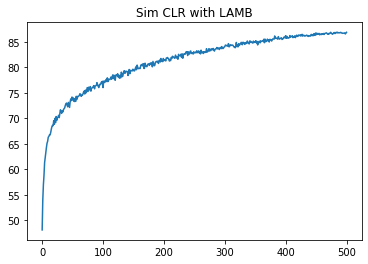

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_acc_1_epoch)
plt.title('Sim CLR with LAMB')